## Import Python Libraries

In [1]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn import preprocessing, metrics
import geopandas as gpd
import fiona
import requests
import zipfile
import io

%matplotlib inline
from matplotlib import pyplot as plt

## Bring in the Data
### Use request.get to load data requested from API into a Response object. Use Requests builtin JSON decoder to read JSON data and load it into a Pandas dataframe.

In [2]:
def create_dataframe(fips,early_year,late_year):
    """
    Submits request for data to the API and creates formatted pandas dataframe for use with clustering algorithms
    
    fips = string defining the 2-digit FIPS code for your state you of interest
    early_year = string defining the 1st date of change period (1996, 2001, 2006 or 2010)
    late_year = string defining the 2nd date of change period (1996, 2001, 2006 or 2010)
    """
    # Format inputs for url
    fips = "'{}'".format(fips)
    early_year = "'{}'".format(early_year)
    late_year = "'{}'".format(late_year)
    
    #API request for Land Cover data in JSON format
    url = "https://coast.noaa.gov/opendata/LandCover/api/v1/distributionOfChangeGainsLossesByLandcovers?$filter=startswith(geoId, {0}) and length(geoId) eq 5 and earlyYear eq {1} and lateYear eq {2}".format(fips, early_year, late_year)
    
    r = requests.get(url, headers={'Accept': 'application/json'})
    data = r.json()
    lca_df = pd.DataFrame(data['value'])
    
    # Set index to the FIPS code and drop Early and Late Year Fields
    lca_df_index = lca_df.set_index('geoId').drop(['earlyYear', 'lateYear'], axis=1)
    
    return lca_df_index


In [128]:
MA_2001_2010 = create_dataframe(25,2001,2010)

In [129]:
MA_2001_2010.head()

,AgrAreaGain,AgrAreaLoss,BarAreaGain,BarAreaLoss,EmwAreaGain,EmwAreaLoss,ForAreaGain,ForAreaLoss,GrsAreaGain,GrsAreaLoss,...,LIDAreaGain,LIDAreaLoss,OSDAreaGain,OSDAreaLoss,SscbAreaGain,SscbAreaLoss,WdwAreaGain,WdwAreaLoss,WtrAreaGain,WtrAreaLoss
geoId,,,,,,,,,,,,,,,,,,,,,
25001,0.02,-0.39,3.79,-2.36,0.28,-0.50,0.10,-4.51,1.05,-0.64,...,2.50,-0.27,1.47,-0.41,0.99,-0.56,0.20,-0.12,1.43,-3.60
25003,0.69,-0.92,0.18,-0.06,0.28,-0.21,0.20,-3.74,0.92,-0.29,...,0.59,-0.07,0.60,-0.14,1.74,-0.27,0.19,-0.33,0.10,-0.12
25005,0.06,-4.07,0.65,-0.33,0.20,-0.24,0.17,-9.21,0.36,-0.84,...,6.31,-0.42,5.85,-1.06,0.79,-0.79,0.07,-1.89,0.05,-0.27
25007,0.02,-0.02,0.41,-0.33,0.02,-0.04,0.11,-0.47,0.34,-0.51,...,0.10,-0.02,0.11,-0.05,0.57,-0.10,0.06,-0.03,0.25,-0.50
25009,0.15,-2.47,2.53,-0.23,0.54,-0.50,0.07,-6.34,0.28,-0.64,...,4.03,-0.35,4.04,-0.80,0.69,-0.49,0.11,-1.48,0.11,-2.49


### Bring a shapefile of the counties

In [73]:
def download_counties(fips,directory):
    """
    Download county boundaries from census.gov ftp site. Unzips file and loads it into a geoPandas dataframe
    
    fips = string defining the 2-digit FIPS code for your state you of interest
    directory = location for file to be downloaded
    """
    fips = str(fips)
        
    map_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    #print('Downloading shapefile...')
        
    # Split on the rightmost / and take everything on the right side of that
    name = map_url.rsplit('/', 1)[-1]
    
    # Remove newline characters from URL
    filename = name.replace("\n", "")
        
    file_zip = os.path.join(directory,filename)
    
    #r = requests.get(map_url)
    #with open(file_zip, "wb") as code:
    #    code.write(r.content)
    
    #z=zipfile.ZipFile(file_zip).extractall(directory)
        
    nation_file_shp = file_zip.replace(".zip",".shp")
        
    # Read into geoPandas Dataframe   
    nation = gpd.read_file(nation_file_shp)
    
    #Select State of Interest
    counties = nation.loc[nation['STATEFP'] == '{0}'.format(fips)].squeeze() 
    counties = counties.rename(columns={'GEOID': 'geoId'})
    
    #return counties
    return counties

In [130]:
counties_gdf = download_counties(25,"C:\\Projects\\junk\\Florida")

In [131]:
counties_gdf

,STATEFP,COUNTYFP,COUNTYNS,geoId,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
57,25,015,00606934,25015,Hampshire,Hampshire County,06,H4,G4020,521,44140,None,N,1365526500,46525649,+42.3394593,-072.6636936,"POLYGON ((-72.992643 42.449094, -72.9925049999..."
61,25,025,00606939,25025,Suffolk,Suffolk County,06,H4,G4020,148,14460,14454,N,150855462,160479920,+42.3385513,-071.0182530,"POLYGON ((-71.033181 42.414206, -71.0330139999..."
347,25,001,00606927,25001,Barnstable,Barnstable County,06,H1,G4020,148,12700,None,A,1020989901,2360346063,+41.7990145,-070.2118803,"POLYGON ((-70.669518 41.51333899999999, -70.67..."
536,25,027,00606940,25027,Worcester,Worcester County,06,H4,G4020,148,49340,None,N,3912560126,177461132,+42.3116934,-071.9402820,"POLYGON ((-72.213973 42.29425699999999, -72.21..."
704,25,019,00606936,25019,Nantucket,Nantucket County,06,H4,G4020,None,None,None,N,119431680,667032050,+41.3058778,-070.1419099,"POLYGON ((-70.493308 41.279975, -70.4368449999..."
917,25,007,00606930,25007,Dukes,Dukes County,06,H1,G4020,None,47240,None,A,267309256,1004275270,+41.3809696,-070.7014995,"POLYGON ((-70.896202 41.37007699999999, -70.90..."
978,25,013,00606933,25013,Hampden,Hampden County,06,H4,G4020,521,44140,None,N,1598126407,44423491,+42.1361975,-072.6356476,"POLYGON ((-72.86841799999999 42.223748, -72.86..."
1032,25,003,00606928,25003,Berkshire,Berkshire County,06,H4,G4020,None,38340,None,N,2400678868,50642922,+42.3753141,-073.2139479,"POLYGON ((-73.410855 42.351746, -73.409318 42...."
1045,25,005,00606929,25005,Bristol,Bristol County,06,H1,G4020,148,39300,None,A,1432461196,357549440,+41.7476243,-071.0889626,"POLYGON ((-71.338787 41.898593, -71.339038 41...."
1323,25,017,00606935,25017,Middlesex,Middlesex County,06,H4,G4020,148,14460,15764,N,2117830644,75814940,+42.4817114,-071.3949166,"POLYGON ((-71.54339399999999 42.466452, -71.54..."


### Create Pandas DataFrame with County Names and Fips Codes from GeoPandas DataFrame

In [113]:
def create_fips_table(dataframe):
    """
    Creates table of FIPS codes and county names for joining to Land Cover DataFrame
    
    dataframe: Geopandas dataframe of State of interest
    
    """
    
    county_attributes = pd.DataFrame(dataframe)
    fips_names = county_attributes[['geoId','NAMELSAD']]
    fips_names.columns = ['geoId','name']
    
    return fips_names

In [132]:
fips_df = create_fips_table(counties_gdf)

### Perform K-means Cluster Analysis

In [133]:
def kmeans_cluster(dataframe, min_cluster, max_cluster):
    """
    Runs a user-defined range of k-means clusters and plots iniertia to help user determine optimal number of clusters
    
    dataframe: Name of pandas dataframe being used for cluster analysis
    min_cluster: Minimum number of clusters
    max_cluster: Maximum number of clusters
    
    """
    clusters = range(min_cluster, max_cluster)
    inertias = []
    
    for k in clusters:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)
    
        # Fit model to samples
        model.fit(input_df)
         
        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)
        
    # Plot inertias
    plt.plot(inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(clusters)
    plt.show()
    
    

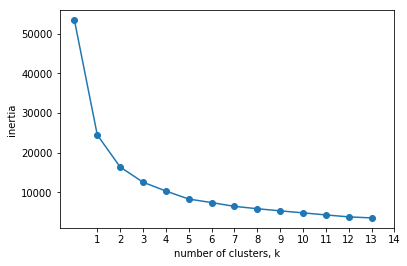

In [134]:
fl_clusters = kmeans_cluster(NJ_2001_2006,1,15)

In [99]:
def kmeans_optimal(dataframe,n_clusters):
    """
    Runs a k-means cluster analysis and returns labels based on the optimal number of clusters
    
    dataframe: Name of pandas dataframe being used for cluster analysis
    n_cluster: Number of clusters
       
    """
    # Create a KMeans instance with X # of clusters: model
    model = KMeans(n_clusters)

    # Fit model to points
    model.fit(dataframe)

    # Determine the cluster labels of new_points: labels
    labels = model.predict(dataframe)
    
    # Print cluster labels of new_points
    print(labels)
    print('Inertia:', model.inertia_)
    print ('Silhouette Score:', metrics.silhouette_score(dataframe, labels, metric='euclidean'))
    
    return labels

In [135]:
optimal_cluster = kmeans_optimal(MA_2001_2010, 6)

[5 0 1 0 1 0 4 0 2 0 1 2 0 3]
Inertia: 51.46733333333334
Silhouette Score: 0.4095468291897029


In [136]:
def map_clusters(labels,dataframe):
    """
    Takes labels from k-means clustering and joins them to Geopandas DataFrame
    
    lables: labels from k-means clustering
    dataframe: Name of pandas dataframe being used for cluster analysis
    """
    labels_dict = {'label':labels}
    labels_df = pd.DataFrame(labels_dict, index=dataframe.index)

    counties_cluster=counties_gdf.join(labels_df, on='geoId')
    
    cluster_plot = counties_cluster.plot(figsize=(15, 15), column='label', legend=True)
    cluster_plot.set_axis_off()
    
    return counties_cluster
       

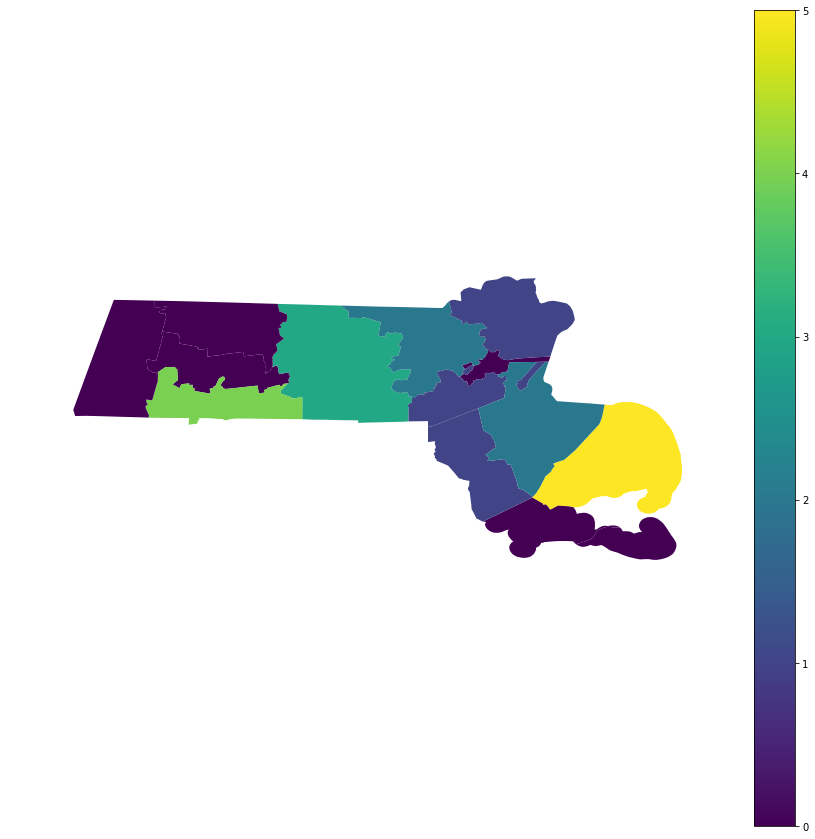

In [137]:
cluster_map = map_clusters(optimal_cluster,MA_2001_2010)